In [1]:
from keras.models import Sequential

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 750 Ti (0000:01:00.0)


In [2]:
from keras.layers import Dense
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
topics_filename = 'lsi_data300b_all.csv'
train_filename = 'train.csv'
data_ncol = 600

In [4]:
df = pd.read_csv(topics_filename, header=None)
df = df.drop(data_ncol,1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.131027,0.095930,0.195295,-0.469097,-0.763666,0.066967,-0.020611,-0.257137,0.130566,-0.023071,...,-0.011458,-0.018594,0.005361,-0.001033,0.003307,0.005174,0.013265,0.004710,0.026169,-0.002679
1,0.009252,0.005731,0.004317,0.000586,0.001910,-0.000159,0.010017,0.004771,0.004544,0.003042,...,-0.007764,0.009553,-0.004478,0.000284,-0.020438,0.008659,-0.008871,0.004932,-0.000559,-0.007585
2,0.051083,0.159485,-0.002575,-0.059695,-0.006306,0.557471,-0.300538,0.587768,0.301793,-0.129490,...,0.009553,0.001102,0.010806,0.035893,0.036417,-0.068212,0.004693,0.010768,-0.060601,0.014747
3,0.002626,0.004496,-0.000483,0.000217,-0.001071,0.002702,-0.001474,-0.000821,0.001163,-0.001771,...,-0.001934,0.002301,0.000774,-0.000096,-0.001945,-0.001019,0.001450,0.001094,0.003011,-0.000182
4,0.003515,0.005035,0.003763,-0.001485,-0.001144,0.005408,-0.001836,0.004339,0.000948,-0.002548,...,0.031361,-0.000116,-0.025799,0.006864,-0.008320,0.002603,0.002629,-0.006734,-0.002938,0.017304


In [5]:
df.shape

(404290, 600)

In [6]:
df_text = pd.read_csv(train_filename).fillna("")
df_text.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
print df_text.shape
print df.shape

(404290, 6)
(404290, 600)


In [8]:
X = df.values
y = df_text.iloc[:,-1:].values.ravel()
del df_text

In [9]:
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed) 

In [10]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint 

In [11]:
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
  # create model
    model = Sequential()
    model.add(Dense(600, input_dim=600, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(600, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X[train], y[train], epochs=10, batch_size=10000, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 74.24%
acc: 73.72%
acc: 73.65%
acc: 74.56%
acc: 73.89%
acc: 73.91%
acc: 73.97%
acc: 73.74%
acc: 74.29%
acc: 74.32%
74.03% (+/- 0.29%)


In [12]:
#create model
model = Sequential()
model.add(Dense(600, input_dim=600, kernel_initializer='uniform', activation='relu'))
model.add(Dense(600, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint 
filepath='weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc' , verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, callbacks=callbacks_list, batch_size=10000)

Train on 270874 samples, validate on 133416 samples
Epoch 1/20
270874/270874 [==============================] - 3s - loss: 0.6328 - acc: 0.6308 - val_loss: 0.6021 - val_acc: 0.6724
Epoch 2/20
270874/270874 [==============================] - 2s - loss: 0.5905 - acc: 0.6931 - val_loss: 0.5718 - val_acc: 0.7032
Epoch 3/20
270874/270874 [==============================] - 2s - loss: 0.5524 - acc: 0.7110 - val_loss: 0.5419 - val_acc: 0.7149
Epoch 4/20
270874/270874 [==============================] - 2s - loss: 0.5224 - acc: 0.7272 - val_loss: 0.5309 - val_acc: 0.7229
Epoch 5/20
270874/270874 [==============================] - 2s - loss: 0.5021 - acc: 0.7396 - val_loss: 0.5219 - val_acc: 0.7268
Epoch 6/20
270874/270874 [==============================] - 2s - loss: 0.4844 - acc: 0.7507 - val_loss: 0.5213 - val_acc: 0.7273
Epoch 7/20
270874/270874 [==============================] - 2s - loss: 0.4687 - acc: 0.7595 - val_loss: 0.5217 - val_acc: 0.7338
Epoch 8/20
270874/270874 [===================

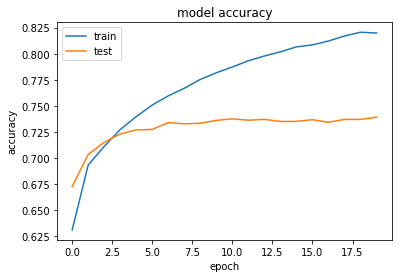

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [14]:
from sklearn.metrics import roc_curve, auc
%matplotlib inline

132960/133416 [============================>.] - ETA: 0s

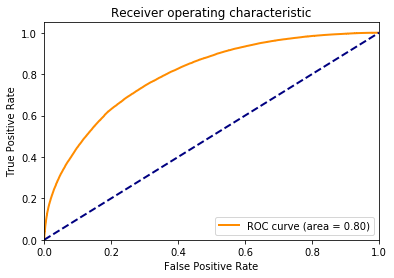

In [15]:
# load weights
model.load_weights("weights.best.hdf5")
y_pred_prob = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

267424/270874 [============================>.] - ETA: 0s 

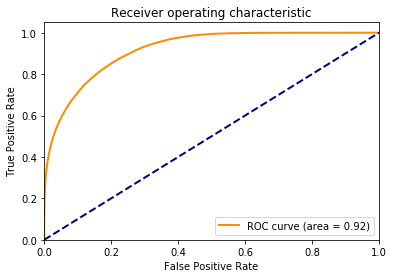

In [16]:
# load weights
model.load_weights("weights.best.hdf5")
y_pred_prob = model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [17]:
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Dropout
#create model
model = Sequential()
model.add(Dropout(0.2, input_shape=(600,)))
model.add(Dense(600, input_dim=600, kernel_initializer='uniform', 
                activation='relu',  kernel_constraint=maxnorm(2.)))
model.add(Dropout(0.2))
model.add(Dense(600, kernel_initializer='uniform', activation='relu',
                kernel_constraint=maxnorm(2.)))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
#sgd = SGD(lr=1.0, momentum=0.9, decay=0.001, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
# checkpoint 
filepath='weights_do.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc' , verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test,y_test), batch_size=10000, callbacks=callbacks_list)

Train on 270874 samples, validate on 133416 samples
Epoch 1/20
270874/270874 [==============================] - 3s - loss: 0.6387 - acc: 0.6260 - val_loss: 0.6067 - val_acc: 0.6510
Epoch 2/20
270874/270874 [==============================] - 2s - loss: 0.6058 - acc: 0.6740 - val_loss: 0.5878 - val_acc: 0.6991
Epoch 3/20
270874/270874 [==============================] - 2s - loss: 0.5833 - acc: 0.6926 - val_loss: 0.5599 - val_acc: 0.7084
Epoch 4/20
270874/270874 [==============================] - 2s - loss: 0.5611 - acc: 0.7028 - val_loss: 0.5444 - val_acc: 0.7155
Epoch 5/20
270874/270874 [==============================] - 2s - loss: 0.5465 - acc: 0.7118 - val_loss: 0.5335 - val_acc: 0.7201
Epoch 6/20
270874/270874 [==============================] - 2s - loss: 0.5366 - acc: 0.7185 - val_loss: 0.5296 - val_acc: 0.7213
Epoch 7/20
270874/270874 [==============================] - 2s - loss: 0.5285 - acc: 0.7219 - val_loss: 0.5255 - val_acc: 0.7246
Epoch 8/20
270874/270874 [===================

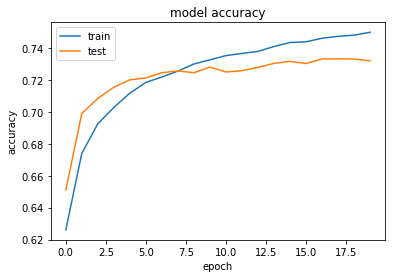

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

133120/133416 [============================>.] - ETA: 0s

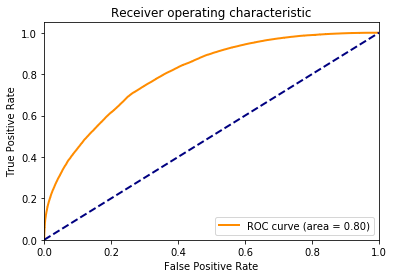

In [19]:
# load weights
model.load_weights("weights_do.best.hdf5")
y_pred_prob = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

268736/270874 [============================>.] - ETA: 0s 

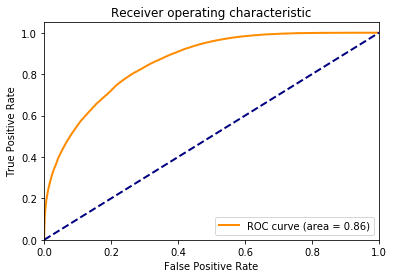

In [20]:
y_pred_prob = model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()